In [13]:
import csv
import pandas as pd
import script.load_data as ld
import script.statistics as stat
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

RANDOM_STATE = 1234

In [2]:
DMM234 = True

In [3]:
# Load and clean data
df = ld.load_data()

,rischio totale,domanda finanziamento,outstanding,totale finanziato gruppo,totale finanziato,rating bplg,rating bnp,assilea,cerved,nuovo cliente,nuovo gruppo,M12,M13,M14,M15,M16,M17,Z17,BLS,ELS,RD,TS,Cessione Contratto Mandatata,Cessione Contratto Semplice,Credito,"Enveloppe loc, opérations Spé",Enveloppe location Transfert,Enveloppe location immobilier,Locaz. Finanziaria Immobiliare,Locazione Finanziaria,Locazione Operativa,Package credito,Package locazione,Riacquisto di crediti,target
0,101402.08,80000.00,21402.08,0.00,28000.0,6.0,6,0.0,NaN,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,20000.00,20000.00,0.00,431900.00,0.0,6.0,6,0.0,6.0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,48666.19,24042.20,24623.99,140401.07,25593.4,NaN,6,0.0,NaN,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,31000.00,31000.00,0.00,0.00,0.0,6.0,6,0.0,NaN,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,19000.00,19000.00,0.00,0.00,0.0,7.0,6,0.0,5.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125701,17286.05,7546.25,9739.80,0.00,0.0,8.0,6,0.0,4.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
125705,2019.00,2019.00,0.00,0.00,0.0,6.0,6,0.0,6.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
125706,58000.00,58000.00,0.00,0.00,0.0,9.0,6,0.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
125801,10058.90,10058.90,0.00,0.00,0.0,7.0,6,0.0,NaN,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [4]:
def deDMM(Xt):
    X = Xt.copy()
    
    X["DMM_"] = np.nan

    for cat in [2, 3, 4]:
        X.loc[X['M1' + str(cat)] == 1, ['DMM_']] = cat - 2
    X = X.drop(columns = ['M12', 'M13', 'M14'])
    return X
    

In [5]:
if DMM234:
    df = deDMM(df)

In [6]:
# Dataset split
X_train, X_test, y_train, y_test = model_selection.train_test_split(df.drop('target', axis=1), df['target'], 
                                                                    test_size=0.2, stratify=df['target'], 
                                                                    random_state=RANDOM_STATE)

In [31]:
from imblearn.ensemble import BalancedRandomForestClassifier
rfc = BalancedRandomForestClassifier(n_estimators=1200, criterion='gini', bootstrap=True, oob_score=True, n_jobs=None, 
                            random_state=RANDOM_STATE, warm_start=False, class_weight='balanced')

# Train the model on training data
rfc.fit(SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_train), y_train)

BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                               class_weight='balanced', criterion='gini',
                               max_depth=None, max_features='auto',
                               max_leaf_nodes=None, max_samples=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=1200,
                               n_jobs=None, oob_score=True, random_state=1234,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [27]:
# Proviamo con XGBoost
import xgboost
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

param_dist = {'n_estimators': 500
              ,'learning_rate': 0.03
              ,'subsample': 1
              ,'max_depth': 6
              ,'colsample_bytree': 0.5
              ,'min_child_weight': 1
             # , 'scale_pos_weight' : 0.22
             }


xgbc = xgboost.XGBClassifier(objective = 'binary:logistic', **param_dist)
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [ ]:
missclassified = np.bitwise_xor(xgbc.predict(X_test), y_test.to_numpy())

In [ ]:
missclassified = np.array(missclassified, dtype=bool)

In [ ]:
proba = xgbc.predict_proba(X_test)

In [ ]:
proba

In [ ]:
prob_miss = proba[missclassified, 1]

In [ ]:
prob_miss

In [ ]:
plt.hist(prob_miss, bins=100)
plt.show()

In [9]:
# Proviamo con CatBoost
def deohe(Xt):
    X = Xt.copy()
    
    if DMM234:  
        X[['DMM']] = X[['nuovo cliente']]
        X[['BU']] = X[['nuovo cliente']]
        X[['Prodotto']] = X[['nuovo cliente']]
        for cat in ['M15', 'M16', 'M17', 'Z17']:
            X.loc[X[cat] == 1, ['DMM']] = cat
        X = X.drop(columns = ['M15', 'M16', 'M17', 'Z17'])
    
    else:
        X[['DMM']] = X[['nuovo cliente']]
        X[['BU']] = X[['nuovo cliente']]
        X[['Prodotto']] = X[['nuovo cliente']]
        for cat in ['M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'Z17']:
            X.loc[X[cat] == 1, ['DMM']] = cat
        X = X.drop(columns = ['M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'Z17'])
    
    
    for cat in ['BLS', 'ELS', 'RD',
       'TS']:
        X.loc[X[cat] == 1, ['BU']] = cat
    X = X.drop(columns = ['BLS', 'ELS', 'RD',
       'TS'])
    
    for cat in ['Cessione Contratto Mandatata', 'Cessione Contratto Semplice',
       'Credito', 'Enveloppe loc, opérations Spé',
       'Enveloppe location Transfert', 'Enveloppe location immobilier',
       'Locaz. Finanziaria Immobiliare', 'Locazione Finanziaria',
       'Locazione Operativa', 'Package credito', 'Package locazione',
       'Riacquisto di crediti']:
        X.loc[X[cat] == 1, ['Prodotto']] = cat
    X = X.drop(columns = ['Cessione Contratto Mandatata', 'Cessione Contratto Semplice',
       'Credito', 'Enveloppe loc, opérations Spé',
       'Enveloppe location Transfert', 'Enveloppe location immobilier',
       'Locaz. Finanziaria Immobiliare', 'Locazione Finanziaria',
       'Locazione Operativa', 'Package credito', 'Package locazione',
       'Riacquisto di crediti'])
    
    return X

In [24]:
from catboost import CatBoostClassifier
grid = {'learning_rate': 0.03,
        'depth': 6,
        'l2_leaf_reg': 7,
        'iterations': 1000,
        'class_weights' : [1, 0.22]
        }
cbc = CatBoostClassifier(loss_function='Logloss', 
                           cat_features = ['DMM', 'BU', 'Prodotto', 'nuovo cliente', 'nuovo gruppo'],
                           **grid)

cbc.fit(deohe(X_train), y_train)

0:	learn: 0.6795147	total: 61ms	remaining: 1m
1:	learn: 0.6663850	total: 109ms	remaining: 54.6s
2:	learn: 0.6540402	total: 166ms	remaining: 55.2s
3:	learn: 0.6428352	total: 244ms	remaining: 1m
4:	learn: 0.6325801	total: 304ms	remaining: 1m
5:	learn: 0.6232096	total: 367ms	remaining: 1m
6:	learn: 0.6139026	total: 436ms	remaining: 1m 1s
7:	learn: 0.6051274	total: 528ms	remaining: 1m 5s
8:	learn: 0.5977881	total: 630ms	remaining: 1m 9s
9:	learn: 0.5906594	total: 698ms	remaining: 1m 9s
10:	learn: 0.5842330	total: 763ms	remaining: 1m 8s
11:	learn: 0.5780089	total: 829ms	remaining: 1m 8s
12:	learn: 0.5725191	total: 887ms	remaining: 1m 7s
13:	learn: 0.5672644	total: 954ms	remaining: 1m 7s
14:	learn: 0.5618990	total: 1.02s	remaining: 1m 7s
15:	learn: 0.5570048	total: 1.08s	remaining: 1m 6s
16:	learn: 0.5526791	total: 1.15s	remaining: 1m 6s
17:	learn: 0.5486991	total: 1.23s	remaining: 1m 6s
18:	learn: 0.5446316	total: 1.3s	remaining: 1m 7s
19:	learn: 0.5410433	total: 1.36s	remaining: 1m 6s
20:	

163:	learn: 0.4584406	total: 9.75s	remaining: 49.7s
164:	learn: 0.4583786	total: 9.8s	remaining: 49.6s
165:	learn: 0.4582643	total: 9.86s	remaining: 49.5s
166:	learn: 0.4581802	total: 9.91s	remaining: 49.4s
167:	learn: 0.4580202	total: 9.95s	remaining: 49.3s
168:	learn: 0.4579215	total: 10s	remaining: 49.2s
169:	learn: 0.4578174	total: 10s	remaining: 49.1s
170:	learn: 0.4576993	total: 10.1s	remaining: 49s
171:	learn: 0.4575481	total: 10.1s	remaining: 48.9s
172:	learn: 0.4574543	total: 10.2s	remaining: 48.7s
173:	learn: 0.4573691	total: 10.2s	remaining: 48.7s
174:	learn: 0.4572983	total: 10.3s	remaining: 48.6s
175:	learn: 0.4572603	total: 10.3s	remaining: 48.4s
176:	learn: 0.4571564	total: 10.4s	remaining: 48.4s
177:	learn: 0.4570559	total: 10.5s	remaining: 48.5s
178:	learn: 0.4569279	total: 10.6s	remaining: 48.5s
179:	learn: 0.4568263	total: 10.6s	remaining: 48.5s
180:	learn: 0.4566845	total: 10.7s	remaining: 48.4s
181:	learn: 0.4566124	total: 10.7s	remaining: 48.3s
182:	learn: 0.45655

323:	learn: 0.4479921	total: 17.8s	remaining: 37.1s
324:	learn: 0.4479642	total: 17.8s	remaining: 37s
325:	learn: 0.4479402	total: 17.9s	remaining: 36.9s
326:	learn: 0.4479069	total: 17.9s	remaining: 36.9s
327:	learn: 0.4478745	total: 18s	remaining: 36.8s
328:	learn: 0.4478273	total: 18s	remaining: 36.7s
329:	learn: 0.4478267	total: 18s	remaining: 36.6s
330:	learn: 0.4477765	total: 18.1s	remaining: 36.6s
331:	learn: 0.4477554	total: 18.1s	remaining: 36.5s
332:	learn: 0.4477072	total: 18.2s	remaining: 36.4s
333:	learn: 0.4476825	total: 18.2s	remaining: 36.3s
334:	learn: 0.4476360	total: 18.3s	remaining: 36.3s
335:	learn: 0.4476075	total: 18.3s	remaining: 36.2s
336:	learn: 0.4475400	total: 18.4s	remaining: 36.2s
337:	learn: 0.4475107	total: 18.4s	remaining: 36.1s
338:	learn: 0.4474651	total: 18.5s	remaining: 36.1s
339:	learn: 0.4474341	total: 18.5s	remaining: 36s
340:	learn: 0.4473954	total: 18.6s	remaining: 35.9s
341:	learn: 0.4473816	total: 18.6s	remaining: 35.8s
342:	learn: 0.4473346	

484:	learn: 0.4421609	total: 25.7s	remaining: 27.3s
485:	learn: 0.4421225	total: 25.8s	remaining: 27.3s
486:	learn: 0.4420722	total: 25.8s	remaining: 27.2s
487:	learn: 0.4420431	total: 25.9s	remaining: 27.1s
488:	learn: 0.4420337	total: 25.9s	remaining: 27.1s
489:	learn: 0.4420294	total: 26s	remaining: 27s
490:	learn: 0.4420288	total: 26s	remaining: 27s
491:	learn: 0.4420072	total: 26.1s	remaining: 26.9s
492:	learn: 0.4419740	total: 26.1s	remaining: 26.9s
493:	learn: 0.4419733	total: 26.2s	remaining: 26.8s
494:	learn: 0.4419403	total: 26.2s	remaining: 26.8s
495:	learn: 0.4419019	total: 26.3s	remaining: 26.7s
496:	learn: 0.4418806	total: 26.3s	remaining: 26.6s
497:	learn: 0.4418520	total: 26.4s	remaining: 26.6s
498:	learn: 0.4418511	total: 26.4s	remaining: 26.5s
499:	learn: 0.4418004	total: 26.5s	remaining: 26.5s
500:	learn: 0.4417456	total: 26.5s	remaining: 26.4s
501:	learn: 0.4417042	total: 26.6s	remaining: 26.4s
502:	learn: 0.4416307	total: 26.6s	remaining: 26.3s
503:	learn: 0.441592

644:	learn: 0.4379265	total: 33.5s	remaining: 18.5s
645:	learn: 0.4379235	total: 33.6s	remaining: 18.4s
646:	learn: 0.4378959	total: 33.6s	remaining: 18.3s
647:	learn: 0.4378563	total: 33.7s	remaining: 18.3s
648:	learn: 0.4378547	total: 33.7s	remaining: 18.2s
649:	learn: 0.4378360	total: 33.8s	remaining: 18.2s
650:	learn: 0.4377812	total: 33.8s	remaining: 18.1s
651:	learn: 0.4377568	total: 33.9s	remaining: 18.1s
652:	learn: 0.4377213	total: 33.9s	remaining: 18s
653:	learn: 0.4377149	total: 34s	remaining: 18s
654:	learn: 0.4376765	total: 34s	remaining: 17.9s
655:	learn: 0.4376526	total: 34.1s	remaining: 17.9s
656:	learn: 0.4376101	total: 34.1s	remaining: 17.8s
657:	learn: 0.4375782	total: 34.1s	remaining: 17.7s
658:	learn: 0.4375589	total: 34.2s	remaining: 17.7s
659:	learn: 0.4375167	total: 34.2s	remaining: 17.6s
660:	learn: 0.4375103	total: 34.3s	remaining: 17.6s
661:	learn: 0.4374768	total: 34.3s	remaining: 17.5s
662:	learn: 0.4374352	total: 34.4s	remaining: 17.5s
663:	learn: 0.437402

806:	learn: 0.4333394	total: 41.6s	remaining: 9.95s
807:	learn: 0.4333326	total: 41.7s	remaining: 9.9s
808:	learn: 0.4333124	total: 41.7s	remaining: 9.85s
809:	learn: 0.4332919	total: 41.8s	remaining: 9.8s
810:	learn: 0.4332600	total: 41.8s	remaining: 9.75s
811:	learn: 0.4332405	total: 41.9s	remaining: 9.7s
812:	learn: 0.4332184	total: 41.9s	remaining: 9.65s
813:	learn: 0.4331880	total: 42s	remaining: 9.6s
814:	learn: 0.4331523	total: 42.1s	remaining: 9.56s
815:	learn: 0.4331274	total: 42.2s	remaining: 9.51s
816:	learn: 0.4330929	total: 42.3s	remaining: 9.46s
817:	learn: 0.4330621	total: 42.3s	remaining: 9.42s
818:	learn: 0.4330226	total: 42.4s	remaining: 9.37s
819:	learn: 0.4330116	total: 42.5s	remaining: 9.32s
820:	learn: 0.4330111	total: 42.5s	remaining: 9.27s
821:	learn: 0.4330108	total: 42.6s	remaining: 9.22s
822:	learn: 0.4329820	total: 42.7s	remaining: 9.17s
823:	learn: 0.4329560	total: 42.7s	remaining: 9.12s
824:	learn: 0.4329555	total: 42.8s	remaining: 9.07s
825:	learn: 0.4329

965:	learn: 0.4298235	total: 50.4s	remaining: 1.77s
966:	learn: 0.4298060	total: 50.4s	remaining: 1.72s
967:	learn: 0.4297825	total: 50.5s	remaining: 1.67s
968:	learn: 0.4297554	total: 50.5s	remaining: 1.62s
969:	learn: 0.4297236	total: 50.6s	remaining: 1.56s
970:	learn: 0.4297031	total: 50.6s	remaining: 1.51s
971:	learn: 0.4296963	total: 50.7s	remaining: 1.46s
972:	learn: 0.4296708	total: 50.7s	remaining: 1.41s
973:	learn: 0.4296365	total: 50.8s	remaining: 1.35s
974:	learn: 0.4296086	total: 50.8s	remaining: 1.3s
975:	learn: 0.4295841	total: 50.9s	remaining: 1.25s
976:	learn: 0.4295554	total: 51s	remaining: 1.2s
977:	learn: 0.4295261	total: 51s	remaining: 1.15s
978:	learn: 0.4295189	total: 51.1s	remaining: 1.09s
979:	learn: 0.4295077	total: 51.1s	remaining: 1.04s
980:	learn: 0.4294684	total: 51.2s	remaining: 991ms
981:	learn: 0.4294583	total: 51.2s	remaining: 939ms
982:	learn: 0.4294085	total: 51.3s	remaining: 887ms
983:	learn: 0.4293983	total: 51.3s	remaining: 835ms
984:	learn: 0.4293

In [45]:
import numpy as np
from sklearn.base import ClassifierMixin
class MixEstimator(ClassifierMixin):
    def __init__(self, est1, est2, est3):
        self.est1 = est1
        self.est2 = est2
        self.est3 = est3
        self.classes_ = [0,1]
    def predict_proba(self, X):
        return np.mean(np.dstack((self.est1.predict_proba(X), self.est2.predict_proba(deohe(X)), 
                                  self.est3.predict_proba(SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X)))), 
                       axis = 2)
    
    def predict(self, X):
        return np.logical_and(np.logical_or(self.est2.predict(deohe(X)), 
                            self.est3.predict(SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X))),
                            self.est1.predict(X))*1

In [46]:
MixEstimator(xgbc, cbc, rfc).predict(X_test)

array([0, 0, 0, ..., 1, 1, 1])

In [47]:
from sklearn.metrics import balanced_accuracy_score
for model, X in [(rfc, SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_test)),
                 (xgbc, X_test),
                 (cbc, deohe(X_test)),
                 (MixEstimator(xgbc, cbc, rfc), X_test)]:
    print(model.__class__.__name__)
    print(balanced_accuracy_score(y_test, model.predict(X), adjusted=True))
    

BalancedRandomForestClassifier
0.47964921755521295
XGBClassifier
0.43488435278274773
CatBoostClassifier
0.5623879352643191
MixEstimator
0.5617434047842087


In [ ]:
from sklearn.metrics import plot_confusion_matrix
for model, X in [(rfc, SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_test)),
                 (xgbc, X_test),
                 (cbc, deohe(X_test)),
                 (MixEstimator(xgbc, cbc, rfc), X_test)]:
    print(model.__class__.__name__)
    plot_confusion_matrix(model, X, y_test, normalize='true')
    plt.show()

In [ ]:
## ENDS

In [ ]:
# Baseline: Random Forest

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

# Impute our data, then train
X_train_imp = imp.transform(X_train)

# Instantiate model
rfc = RandomForestClassifier(n_estimators=1200, criterion='gini', max_depth=None, 
                            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                            max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                            min_impurity_split=None, bootstrap=True, oob_score=True, n_jobs=None, 
                            random_state=RANDOM_STATE, warm_start=False, class_weight=None, 
                            ccp_alpha=0.0, max_samples=None)

# Train the model on training data
rfc.fit(X_train_imp, y_train)

In [ ]:
from sklearn.utils import resample
df_majority = df[df.target==1]
df_minority = df[df.target==0]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=17000,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.target.value_counts()
# 1    49
# 0    49
# Name: balance, dtype: int64

In [ ]:
## ENDS

In [ ]:
# Baseline: Random Forest

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

# Impute our data, then train
X_train_imp = imp.transform(X_train)

# Instantiate model
rfc = RandomForestClassifier(n_estimators=1200, criterion='gini', max_depth=None, 
                            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                            max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                            min_impurity_split=None, bootstrap=True, oob_score=True, n_jobs=None, 
                            random_state=RANDOM_STATE, warm_start=False, class_weight=None, 
                            ccp_alpha=0.0, max_samples=None)

# Train the model on training data
rfc.fit(X_train_imp, y_train)

In [ ]:
from sklearn.utils import resample
df_majority = df[df.target==1]
df_minority = df[df.target==0]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=17000,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.target.value_counts()
# 1    49
# 0    49
# Name: balance, dtype: int64

In [ ]:
## ENDS

In [ ]:
# Baseline: Random Forest

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

# Impute our data, then train
X_train_imp = imp.transform(X_train)

# Instantiate model
rfc = RandomForestClassifier(n_estimators=1200, criterion='gini', max_depth=None, 
                            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                            max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                            min_impurity_split=None, bootstrap=True, oob_score=True, n_jobs=None, 
                            random_state=RANDOM_STATE, warm_start=False, class_weight=None, 
                            ccp_alpha=0.0, max_samples=None)

# Train the model on training data
rfc.fit(X_train_imp, y_train)

BalancedRandomForestClassifier


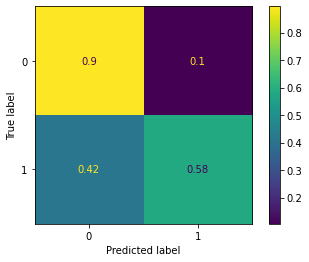

XGBClassifier


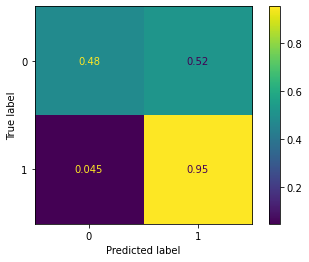

CatBoostClassifier


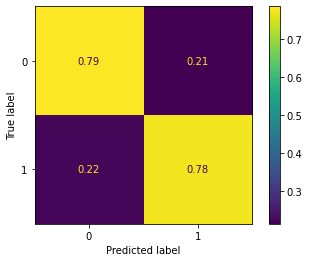

MixEstimator


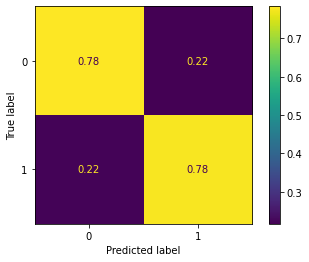

In [50]:
from sklearn.utils import resample
df_majority = df[df.target==1]
df_minority = df[df.target==0]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=17000,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.target.value_counts()
# 1    49
# 0    49
# Name: balance, dtype: int64

In [ ]:
## ENDS

In [ ]:
# Baseline: Random Forest

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

# Impute our data, then train
X_train_imp = imp.transform(X_train)

# Instantiate model
rfc = RandomForestClassifier(n_estimators=1200, criterion='gini', max_depth=None, 
                            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                            max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                            min_impurity_split=None, bootstrap=True, oob_score=True, n_jobs=None, 
                            random_state=RANDOM_STATE, warm_start=False, class_weight=None, 
                            ccp_alpha=0.0, max_samples=None)

# Train the model on training data
rfc.fit(X_train_imp, y_train)

In [ ]:
from sklearn.utils import resample
df_majority = df[df.target==1]
df_minority = df[df.target==0]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=17000,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.target.value_counts()
# 1    49
# 0    49
# Name: balance, dtype: int64

In [ ]:
df = df_downsampled